In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import Train set and Test set

In [9]:
train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

print('train_set shape', train_set.shape)
print('test_set shape', test_set.shape)

train_set.head()

train_set shape (42000, 785)
test_set shape (28000, 784)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [211]:
## Extract train_set to train_imgs and train_labels
train_labels = train_set.as_matrix()[:,0]
train_img = train_set.as_matrix()[:,1:]
test_img = test_set.as_matrix()[:,:]

print('train_labels shape', train_labels.shape)
print('train_img shape', train_img.shape)
print('test set shape', test_img.shape)

train_labels shape (42000,)
train_img shape (42000, 784)
test set shape (28000, 784)


# Data visualization

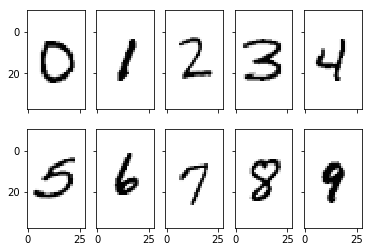

In [27]:
fig, ax = plt.subplots(2,5, sharex = True, sharey = True)
ax = ax.flatten()

for i in range(0,10):
    ax[i].imshow(train_img[train_labels == i,:][30].reshape(28,28), cmap = 'Greys')
    
plt.show()

# Normalization

In [221]:
## normalization using min max to (-1, 1)
train_img_norm = (train_img/255 - 0.5)*2
test_img_norm = (test_img/255 - 0.5)*2
print(test_img_norm.shape)

(28000, 784)


# Build CNN class

In [225]:
class CNN(object):
    
    import tensorflow as tf
    '''
    This class is consist of 2 conv layers, 2 max-pooling layers, 1 dense layer and output layer.
    '''
    
    def __init__(self, learning_rate = 10**-4, batchsize = 2**8, dropout_rate = 0.5, epochs = 40, l2_scale = 10**-4):
        
        self.learning_rate = learning_rate
        self.batchsize = batchsize
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.l2_scale = l2_scale
        
    def build(self, X_train, Y_train):
        
        # build empty graph
        m = X_train.shape[0]
        g = tf.Graph()
        
        with g.as_default():
            
            X_train = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]], name = 'X')
            tf_y = tf.placeholder(tf.int32, shape=[None], name='Y')
            Y_train = tf.one_hot(indices = tf.cast(tf_y, tf.int32), dtype=tf.int32, depth = 10)
            
            dropout_rate = tf.placeholder(tf.float32, name='dropout_rate')
            is_train = tf.placeholder(tf.bool, name='is_train')
            l2_scale = tf.placeholder(tf.float32, name='l2_scale')
            ## placeholder => 'X', 'Y', 'dropout_rate', 'is_train'
            
            ## Fitst conv-> max-pool layer
            h1 = tf.layers.conv2d(tf.reshape(X_train, shape=[-1,28,28,1]), 32, (5,5), activation = tf.nn.relu,
                                 kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d())
            h1_pool = tf.layers.max_pooling2d(h1, pool_size = (2,2), strides = (2,2))
            
            ## second conv-> max-pool layer
            h2 = tf.layers.conv2d(h1_pool, 64, (5,5), activation = tf.nn.relu,
                                 kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                 kernel_regularizer = tf.contrib.layers.l2_regularizer(scale = l2_scale))
            h2_pool = tf.layers.max_pooling2d(h2, pool_size = (2,2), strides = (2,2))
            
            ## dense=>dropout and output layer
            n_shape = h2_pool.get_shape().as_list()
            h3 = tf.layers.dense(tf.reshape(h2_pool, shape=[-1,np.prod(n_shape[1:])]),
                                 units = 1024, activation = tf.nn.relu,
                                kernel_initializer = tf.contrib.layers.xavier_initializer())
            h3_dropout = tf.layers.dropout(h3, rate = dropout_rate, training = is_train)
            
            h4 = tf.layers.dense(h3_dropout, units = 10, activation = None,
                                kernel_initializer = tf.contrib.layers.xavier_initializer())
            
            ## Cost and eval metrices
            cost_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = h4, labels = Y_train), name='cost')
            loss = tf.reduce_sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))/m
            
            cost = cost_entropy + loss
            
            Y_pred = tf.cast(tf.argmax(h4, axis = 1), tf.int32, 'Y_pred')
            predictions = {'cor_pred': tf.equal(Y_pred, tf_y, name='cor_pred'),
                           'wrong_pred': tf.logical_not(tf.equal(Y_pred, tf_y), name='wrong_pred')}
            
            accuracy = tf.reduce_mean(tf.cast(predictions['cor_pred'], tf.float32), name='accuracy')
            
            ## Optimizer 
            optimizer = tf.train.AdamOptimizer(self.learning_rate, name='train_op')
            optimizer = optimizer.minimize(cost)
            
            ## saver and variable initialize
            self.init = tf.global_variables_initializer()            
            self.saver = tf.train.Saver()
            
            ## placeholder => 'X', 'Y', 'dropout_rate', 'is_train'
            
        self.sess = tf.Session(graph = g)
        self.sess.run(self.init)
        ## End build method
        
    def batch_generation(self, X_train, Y_train, batchsize, shuffle = True):
        
        m = X_train.shape[0] # num samples
        X_temp = X_train.copy()
        Y_temp = Y_train.copy()
        
        if shuffle == True:
            
            idx = np.arange(m)
            np.random.shuffle(idx)
            
            X_temp = X_temp[idx,:]
            Y_temp = Y_temp[idx]
        
        for i in range(0, m, batchsize):
            yield(X_temp[i:i+batchsize,:], Y_temp[i:i+batchsize])
    
    ## End batch_generation
    def save(self, epoch):
        self.saver.save(self.sess, './tflayers-model/'+'CNN_model.ckpt', global_step = epoch)
        
    def load(self, epoch):
        print('Loading model')
        self.saver.restore(self.sess, './tflayers-model/'+'CNN_model.ckpt-' + str(epoch))
        
    def predict(self, X_test):
        feed_dict = {'X:0':X_test, 'dropout_rate:0':1, 'is_train:0':False}
        Y_pred = self.sess.run('Y_pred:0', feed_dict = feed_dict)
        return Y_pred
    
    def train(self, X_train, Y_train, X_dev=None, Y_dev=None):
        
        '''
        This method will train model of graph g
        '''
        self.build(X_train, Y_train)
        
        for i in range(self.epochs):
            
            batch = self.batch_generation(X_train, Y_train, self.batchsize, shuffle = True)
            cost_avg = 0
            train_acc_avg = 0
            count = 0

            for k, (X_batch, Y_batch) in enumerate(batch):
                count += 1
                ## placeholder => 'X', 'Y', 'dropout_rate', 'is_train'
                feed_dict = {'X:0':X_batch, 'Y:0':Y_batch, 'dropout_rate:0':self.dropout_rate,
                             'is_train:0':True, 'l2_scale:0':self.l2_scale}
                _, train_acc, cost = self.sess.run(['train_op','accuracy:0', 'cost:0'], feed_dict = feed_dict)
                
                train_acc_avg += train_acc
                cost_avg += cost
                
            if X_dev is not None and Y_dev is not None:
                feed_dict = {'X:0':X_dev, 'Y:0':Y_dev, 'dropout_rate:0':1, 'is_train:0':False}
                dev_acc = self.sess.run('accuracy:0', feed_dict = feed_dict)
            else: dev_acc = 0
            
            print('Epochs : {:d} Train ACC Avg : {:.4f} Dev ACC : {:.4f} Cost Avg : {:.2f} '
                  .format(i, train_acc_avg/count, dev_acc, cost_avg/count))

In [226]:
from sklearn.model_selection import train_test_split

X_train, X_dev, Y_train, Y_dev = train_test_split(train_img_norm, train_labels, test_size = 0.05, stratify = train_labels)

print('X_train shape', X_train.shape)
print('X_dev shape', X_dev.shape)
print('Y_train shape', Y_train.shape)
print('Y_dev shape', Y_dev.shape)

## Check stratify
print(pd.Series(Y_train).value_counts()/len(Y_train))
print(pd.Series(Y_dev).value_counts()/len(Y_dev))

X_train shape (39900, 784)
X_dev shape (2100, 784)
Y_train shape (39900,)
Y_dev shape (2100,)
1    0.111529
7    0.104787
3    0.103609
9    0.099724
2    0.099449
6    0.098496
0    0.098371
4    0.096942
8    0.096742
5    0.090351
dtype: float64
1    0.111429
7    0.104762
3    0.103333
9    0.099524
2    0.099524
6    0.098571
0    0.098571
4    0.097143
8    0.096667
5    0.090476
dtype: float64


In [227]:
epochs = 60
cnn = CNN(epochs = epochs, l2_scale = 10**-3)
cnn.train(X_train, Y_train, X_dev, Y_dev)
cnn.save(epochs)

Epochs : 0 Train ACC Avg : 0.7781 Dev ACC : 0.9281 Cost Avg : 0.84 
Epochs : 1 Train ACC Avg : 0.9350 Dev ACC : 0.9567 Cost Avg : 0.22 
Epochs : 2 Train ACC Avg : 0.9586 Dev ACC : 0.9671 Cost Avg : 0.14 
Epochs : 3 Train ACC Avg : 0.9679 Dev ACC : 0.9743 Cost Avg : 0.11 
Epochs : 4 Train ACC Avg : 0.9733 Dev ACC : 0.9733 Cost Avg : 0.09 
Epochs : 5 Train ACC Avg : 0.9779 Dev ACC : 0.9786 Cost Avg : 0.07 
Epochs : 6 Train ACC Avg : 0.9802 Dev ACC : 0.9805 Cost Avg : 0.07 
Epochs : 7 Train ACC Avg : 0.9820 Dev ACC : 0.9795 Cost Avg : 0.06 
Epochs : 8 Train ACC Avg : 0.9845 Dev ACC : 0.9810 Cost Avg : 0.05 
Epochs : 9 Train ACC Avg : 0.9856 Dev ACC : 0.9819 Cost Avg : 0.05 
Epochs : 10 Train ACC Avg : 0.9873 Dev ACC : 0.9833 Cost Avg : 0.04 
Epochs : 11 Train ACC Avg : 0.9882 Dev ACC : 0.9852 Cost Avg : 0.04 
Epochs : 12 Train ACC Avg : 0.9888 Dev ACC : 0.9819 Cost Avg : 0.04 
Epochs : 13 Train ACC Avg : 0.9896 Dev ACC : 0.9852 Cost Avg : 0.03 
Epochs : 14 Train ACC Avg : 0.9902 Dev ACC :

In [228]:
Y_test_pred = cnn.predict(test_img_norm)
print(Y_test_pred.shape)
Y_test_pred_pandas = pd.DataFrame(Y_test_pred)
Y_test_pred_pandas.to_csv('Output.csv')

(28000,)


In [180]:
cnn.load(epochs)

Loading model
INFO:tensorflow:Restoring parameters from ./tflayers-model/CNN_model.ckpt-20
